In [104]:
import numpy as np
from skimage import io, morphology
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.transform import rotate
from scipy.ndimage import median_filter
import math

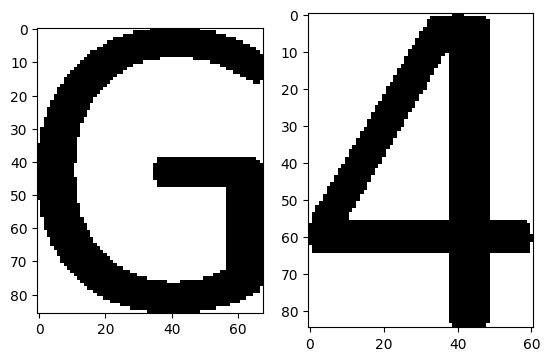

In [105]:
def get_image_gray(path):
    # Charger l'image
    image = io.imread(path)
    # Vérifier le nombre de canaux
    if len(image.shape) == 3:
        if image.shape[2] == 2:
            image_gray = np.min(image, axis=2).astype(np.uint8)
        elif image.shape[2] == 3 or image.shape[2] == 4:
            image_gray = np.min(image[..., :3], axis=2).astype(np.uint8)
        else:
            raise ValueError("L'image a un nombre de canaux inattendu.")
    else:
        image_gray = image.astype(np.uint8)
    return image_gray


def get_car_binary(path):
    image_gray = get_image_gray(path)
    image_binary = image_gray > 100         # Seuil choissit arbitrairement mais marche bien avec toute la base de données des caractères
    return image_binary

# Construction du dictionnaire des caractères utilisé pour la convolution
lettre_folder = 'ressources/ressources/lettres/'
chiffre_folder = 'ressources/ressources/chiffres/'

alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
chiffre_list = '0123456789'

dictionnaire_lettre = {}
dictionnaire_chiffre = {}

# On souhaite redimensionner nos images en rognant parfaitement nos images sur les caractères (i.e. pas d'espace blanc autour)

def segmentation_colonne(image):
    start_colonne, end_colonne = None, None
    flag = 0
    # Segmenter par colonnes
    for colonne in range(image.shape[1]):
        has_black_pixel = np.any(image[:, colonne] == 0)
        if has_black_pixel and flag == 0:
            flag = 1
            start_colonne = colonne
        elif not has_black_pixel and flag == 1:
            flag = 0
            end_colonne = colonne
            if end_colonne - start_colonne >= 5:
                return image[:, start_colonne:end_colonne]
    return image # pas de segmentation trouvée


def segmentation_ligne(image):
    start_ligne, end_ligne = None, None
    flag = 0
    # Segmenter par lignes
    for ligne in range(image.shape[0]):
        has_black_pixel = np.any(image[ligne, :] == 0)
        if has_black_pixel and flag == 0:
            flag = 1
            start_ligne = ligne
        elif not has_black_pixel and flag == 1:
            flag = 0
            end_ligne = ligne
            # Vérifie que l'écart entre start_ligne et end_ligne est d'au moins 10 pixels
            if end_ligne - start_ligne >= 5:
                return image[start_ligne:end_ligne, :]
    return image  # Pas de segmentation trouvée


def segmentation_ligne_colonne(image):
    image_segmented_colonne = segmentation_colonne(image)
    return segmentation_ligne(image_segmented_colonne)


# Ajouter les lettres au dictionnaire
for lettre in alphabet:
    dictionnaire_lettre[lettre] = segmentation_ligne_colonne(get_car_binary(lettre_folder + lettre + '.png'))

# Ajouter les chiffres au dictionnaire
for chiffre in chiffre_list:
    image_chiffre = get_car_binary(chiffre_folder + chiffre + '.png')
    image_chiffre_pre_segmented = image_chiffre[10:, 10:]
    dictionnaire_chiffre[chiffre] = segmentation_ligne_colonne(image_chiffre_pre_segmented)

# Affichage d'un exemple
plt.subplot(1, 2, 1)
plt.imshow(dictionnaire_lettre['G'], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(dictionnaire_chiffre['4'], cmap='gray')
plt.show()


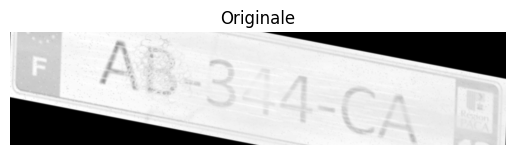

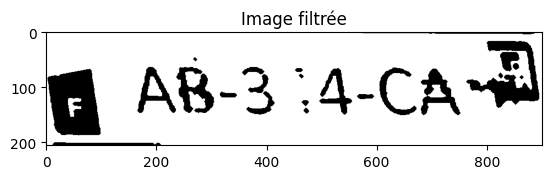

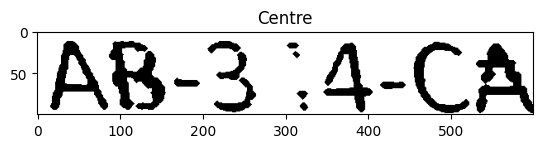

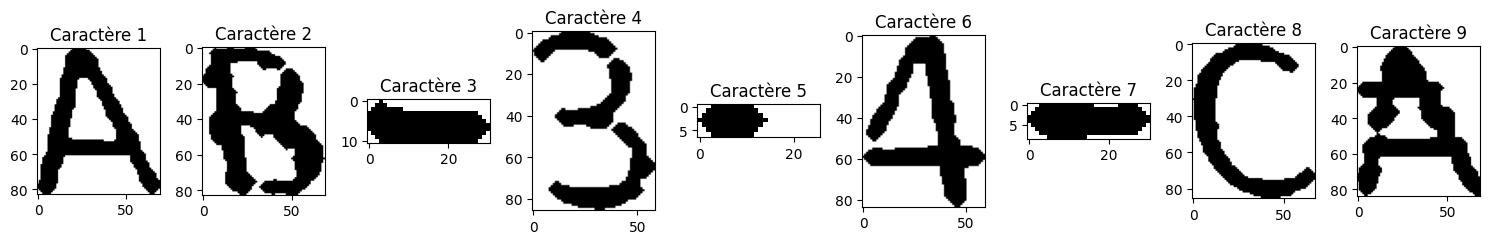

AS-364-CA
AS-364-CA


In [106]:
def convert2binary(image_gray, seuil):
    return image_gray > seuil

def smooth_image_median(image):
    return median_filter(image, size=2)

path = 'images_horribles/images_horribles/plaque-005.png'
# path = 'ressources/ressources/plaque-003.png'

im_plaque_1 = get_image_gray(path)
plt.title('Originale')
plt.imshow(im_plaque_1, cmap='gray')
plt.axis('off')
plt.show()

im_plaque_1_bin = convert2binary(im_plaque_1,230)           # pour la 3ème plaque c'est 170  # 4ème c'est 230
# Pour la 5ème :
angle = 10.5
im_plaque_1_bin = rotate(im_plaque_1_bin, angle, mode='constant', cval=1)
smoothed_image_median = smooth_image_median(im_plaque_1_bin)



smoothed_image_median = smooth_image_median(im_plaque_1_bin)

smoothed_image_median_new = smooth_image_median(smoothed_image_median)
smoothed_image_median = smoothed_image_median_new
# Nettoyage de l'image (suppression du bruit)
cleaned = morphology.remove_small_objects(smoothed_image_median, min_size=50)
# Dilation
dilated_image = morphology.dilation(cleaned, morphology.square(6))
combined_image = np.logical_and(1- dilated_image, 1 - cleaned)

    
final_image_memory = morphology.dilation(combined_image, morphology.square(1))
for i in range(3):
    final_image = morphology.binary_dilation(final_image_memory)
    final_image_memory = final_image
    
final_image =  1-final_image
plt.title('Image filtrée')
plt.imshow(final_image, cmap='gray')
plt.show()


total_columns = final_image.shape[1]
total_lines = final_image.shape[0] 
start_line = (total_lines - 100) // 2  
end_line = start_line + 100 
start_column = (total_columns - 600) // 2  
end_column = start_column + 600 

image_centre = final_image[start_line:end_line, start_column:end_column]

# Afficher l'image
plt.imshow(image_centre, cmap='gray')
plt.title('Centre')
plt.show()



def segmentation_image(image):
    liste_image_caractere = []  
    N = 10
    start_colonne = None
    flag = 0
    
    for colonne in range(image.shape[1]):
        has_black_pixel = np.any(image[:, colonne] == 0)
        if has_black_pixel and flag == 0:
            flag = 1
            start_colonne = colonne
        elif not has_black_pixel and flag == 1:
            flag = 0
            end_colonne = colonne
            image_car = image[:, start_colonne:end_colonne]
            liste_image_caractere.append(image_car)
    if flag == 1:
        image_car = image[:, start_colonne:]
        liste_image_caractere.append(image_car)
    return liste_image_caractere

def identify_character(image_unknown, index):
    # Initialiser les variables pour stocker la meilleure correspondance
    meilleur_score = -np.inf
    meilleur_caractere = None
    
    if index in {1, 2, 8, 9}:
        dictionnaire = dictionnaire_lettre
    elif index in {4, 5, 6}:
        dictionnaire = dictionnaire_chiffre
    else:
        return '-', None
    # Parcourir tous les caractères dans le dictionnaire
    for caractere, image_modele in dictionnaire.items():
        # Redimensionner l'image inconnue à la taille de l'image modèle
        image_resized = resize(image_unknown, image_modele.shape, mode='reflect', anti_aliasing=False, preserve_range=True)
        correspondance = np.sum(image_resized == image_modele)
        score = correspondance / image_modele.size
        if score > meilleur_score:
            meilleur_score = score
            meilleur_caractere = caractere
    
    return meilleur_caractere, meilleur_score

# Afficher chaque image séparément sur une seule figure
liste_image_caractere = segmentation_image(image_centre)
plt.figure(figsize=(15, 3))

i = 0
plaque = []
for image in liste_image_caractere:
    image = segmentation_ligne(image)
    plt.subplot(1, 9, i + 1)
    plt.title(f'Caractère {i + 1}')
    plt.imshow(image, cmap='gray')
    meilleur_caractere, meilleur_score = identify_character(image, i+1)
    plaque.append(meilleur_caractere) 
    i += 1
    
plt.tight_layout()
plt.show()
print(''.join(plaque))
plaque[2] = '-'
plaque[6] = '-'
plaque_name = ''.join(plaque)
print(plaque_name)




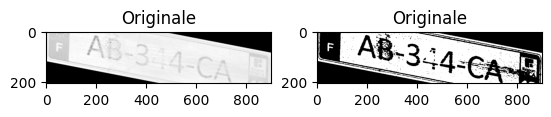

In [107]:
path = 'images_horribles/images_horribles/plaque-005.png'

im_plaque_2 = get_image_gray(path)
plt.subplot(1,2,1)
plt.title('Originale')
plt.imshow(im_plaque_2, cmap='gray')
plt.subplot(1,2,2)
im_plaque_2_bin = convert2binary(im_plaque_2,230)
plt.title('Originale')
plt.imshow(im_plaque_2_bin, cmap='gray')
plt.show()

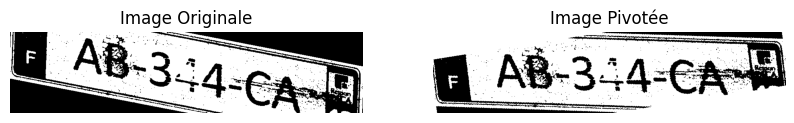

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rotate



# Définir l'angle de rotation
angle = 9  # Angle de rotation en degrés

# Pivoter l'image
image_rotated = rotate(im_plaque_2_bin, angle, mode='constant', cval=1)  # cval=1 pour le blanc

# Affichage de l'image originale et de l'image pivotée
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(im_plaque_2_bin, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Image Pivotée')
plt.imshow(image_rotated, cmap='gray')
plt.axis('off')

plt.show()

# Correction de l'orientation de l'image

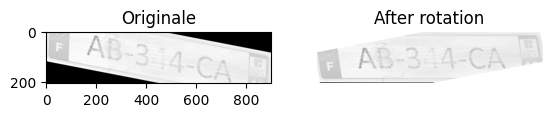

In [109]:
def trouver_ligne_basse_colonne(image, colonne):
    for ligne in range(image.shape[0] - 1, -1, -1):
        if image[ligne, colonne] == 1:
            return ligne
    return None

def get_correct_orientation(image_gray):
    im_bin = image_gray > 10
    nb_colonnes = im_bin.shape[1]
    delta = 10
    colonne_end = (nb_colonnes//2) - delta
    colonne_start = delta

    # Calcul de l'angle
    ligne_start = trouver_ligne_basse_colonne(im_bin, colonne_start)
    ligne_end = trouver_ligne_basse_colonne(im_bin, colonne_end)
    y = ligne_start - ligne_end
    x = colonne_start - colonne_end
    angle = math.atan2(y, x)*180/(np.pi) + 180
    im_rot = rotate(im_plaque_1, angle, mode='constant', cval=1)
    return im_rot

 
# Chargement de l'image
path = 'images_horribles/images_horribles/plaque-005.png'
# path = 'ressources/ressources/plaque-003.png'

im_plaque_1 = get_image_gray(path)

plt.subplot(1,2,1)
plt.title('Originale')
plt.imshow(im_plaque_1, cmap='gray')



    
im_rot =  get_correct_orientation(im_plaque_1)
plt.subplot(1,2,2)  
plt.title('After rotation')
plt.imshow(im_rot, cmap='gray')
plt.axis('off')
plt.show()